## Importowanie bibliotek potrzebnych do realizacji zadania

In [131]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import os
import sys
from pathlib import Path

import warnings

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn as sk
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

from tensorflow import keras
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support

import pickle
import shap

working_dir = Path(os.getcwd()).parent
sys.path.append(os.path.join(working_dir, 'Preprocessing\\'))

from data_aggregator import *
from season import *
from parameters import *
from team import *

from split_start import *
from split_block import *
from prepare_dataset import *

## Przygotowanie danych - pobranie przetworzonych danych do pamięci podręcznej

In [14]:
no_last_matches = 3

data_aggregator = DataAggregator()

all_seasons, all_data_past =\
                    data_aggregator.get_data_for_seasons([Season.y2010, Season.y2011,
                                                         Season.y2012, Season.y2013,
                                                         Season.y2014, Season.y2015, Season.y2016], 
                                                         Parameters(no_last_matches=no_last_matches))

# Przygotowaniei podstawowych wartości

In [15]:
all_seasons['match_date'] = pd.to_datetime(all_seasons['match_date'])

In [16]:
list_of_parameters = ['home_team_score',
                        'away_team_score', 
                        'home_team_seasons_played',
                        'away_team_seasons_played', 
                        'home_team_last_season_points',
                        'away_team_last_season_points', 
                        'home_players_avg_age',
                        'away_players_avg_age', 
                        'home_players_avg_rating',
                        'away_players_avg_rating', 
                        'home_elo_rating', 
                        'away_elo_rating',
                        'avg_home_win_odds', 
                        'avg_draw_odds', 
                        'avg_away_win_odds',
                        'home_avg_corners', 
                        'away_avg_corners', 
                        'home_avg_shots',
                        'away_avg_shots', 
                        'home_won_games', 
                        'away_won_games', 
                        'home_tied_games',
                        'away_tied_games', 
                        'home_lost_games', 
                        'away_lost_games',
                        'home_scored_goals', 
                        'away_scored_goals'
                     ]

In [24]:
dataset = prepare_dataset(all_seasons, list_of_parameters, all_data_past,
                          add_direct = True, avg = 3, train_size = 0.9, test_size = 0.1,
                          undersample = True, globalCS = False)

In [25]:
Counter(dataset['y_train'])

Counter({1: 603, 0: 521, 2: 595})

## Algorytm SVM

In [26]:
fromStart = StartSplit(n_blocks = 8, train_split = 200, scoring = metrics.accuracy_score)

In [27]:
parameters = {'C':[1,2],'gamma':[0.095,0.001,0.0015], 'kernel':['rbf','linear']}

parameters = {'C': stats.uniform(1, 5),
              'gamma': stats.uniform(0.001, 0.05),
              'kernel':['rbf','linear']}

In [155]:
Xtrain90 = dataset['X_train']

scaler = StandardScaler()
scaler.fit(Xtrain90)

#Zapis wartości do późniejszego skalowania danych
ex_filename = os.path.join(os.path.join(Path(os.getcwd()), 'saved'), 'SVM_scaler.pkl')
with open(ex_filename, "wb") as f:
    pickle.dump(scaler, f)

Xtrain = scaler.transform(dataset['X_train'])
Ytrain = dataset['y_train']

Xtest = scaler.transform(dataset['X_test'])
Ytest = dataset['y_test']

In [156]:
svc_grid = RandomizedSearchCV(SVC(), \
                   param_distributions = parameters,\
                   scoring = 'f1_macro', \
                   cv = fromStart.generate_cv(Xtrain, Ytrain), \
                   n_jobs=-1, \
                   n_iter = 50, \
                   random_state = 44)

In [157]:
svc_grid.fit(Xtrain, Ytrain)

RandomizedSearchCV(cv=<generator object StartSplit.generate_cv at 0x000001176DFDC4C8>,
                   estimator=SVC(), n_iter=50, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001176BDC4A08>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001176BDA4A08>,
                                        'kernel': ['rbf', 'linear']},
                   random_state=44, scoring='f1_macro')

In [158]:
print(f"Najlepsze znalezione parametry: {svc_grid.best_params_}")

Najlepsze znalezione parametry: {'C': 3.560291686892903, 'gamma': 0.0030492848805430566, 'kernel': 'rbf'}


In [159]:
#Odczyt wyników
predicted_values= svc_grid.predict(Xtest)

print('\n##################################\nAccuracy: ')

print(metrics.accuracy_score(Ytest, from_start_predicted))

temp = precision_recall_fscore_support(Ytest, from_start_predicted, average='macro')

temp = precision_recall_fscore_support(Ytest, from_start_predicted, average='macro')
print(f'\n##################################\nPrecision: {temp[0]}\nRecall: {temp[1]}\nfscore: {temp[2]}')


best = clf_fromStart_grid.best_estimator_
best.set_params(probability=True)

y_probas_svm = cross_val_predict(best, Xtest, Ytest, cv=3, method="predict_proba")
roc_ovo_macro = roc_auc_score(dataset['y_test'], y_probas_svm, multi_class="ovo", average="macro")
roc_ovr_macro = roc_auc_score(dataset['y_test'], y_probas_svm, multi_class="ovr", average="macro")
print(f"\n##################################\nOvO: {roc_ovo_macro}\nOvR: {roc_ovr_macro}")

print(f"\n##################################\n")
print(f'Poprawnie sklasyfikowane przykłady: ', end = '')
print(f"{sorted(Counter(dataset['y_test'][predicted_values== Ytest]).items(), key = lambda el : el[0])}")

print(f'Błędnie sklasyfikowane przykłady: ', end = '')
print(f"{sorted(Counter(dataset['y_test'][predicted_values!= Ytest]).items(), key = lambda el : el[0])}")

print(f"\n##################################\n")
print(f"Macierz pomyłek: \n{confusion_matrix(Ytest, from_start_predicted)}")


##################################
Accuracy: 
0.4973821989528796

##################################
Precision: 0.4878759021143429
Recall: 0.49900302918263967
fscore: 0.48447554857479896

##################################
OvO: 0.6151219132499173
OvR: 0.6105643243239842

##################################

Poprawnie sklasyfikowane przykłady: [(0, 18), (1, 35), (2, 42)]
Błędnie sklasyfikowane przykłady: [(0, 47), (1, 24), (2, 25)]

##################################

Macierz pomyłek: 
[[18 21 26]
 [13 35 11]
 [10 15 42]]


## Wyliczenie wartości shapley'a dla standardowego podejścia SNN

In [37]:
shap.initjs()

In [67]:
X_train_shap = np.array(dataset['X_train'])
X_test_shap = np.array(dataset['X_test'])

In [160]:
svc_model = SVC(**svc_grid.best_params_)
svc_model.fit(dataset['X_train'], dataset['y_train'])

SVC_proba = svc_model.set_params(probability = True)
SVC_proba

SVC(C=3.560291686892903, gamma=0.0030492848805430566, probability=True)

In [134]:
X_train_shap_summary = shap.sample(X_train_shap, 100)
explainer = shap.KernelExplainer(SVC_proba.predict, X_train_shap_summary)
shap_values = explainer.shap_values(X_test_shap, nsamples=100)

In [135]:
#Zapis wyliczonych wartości do pliku
ex_filename = os.path.join(os.path.join(Path(os.getcwd()), 'saved'), 'explainer_SVM.pkl')
with open(ex_filename, "wb") as f:
    pickle.dump(explainer.expected_value, f)
ex_filename = os.path.join(os.path.join(Path(os.getcwd()), 'saved'), 'shap_values_SVM.pkl')
with open(ex_filename, "wb") as f:
    pickle.dump(shap_values, f)

In [140]:
#Odczyt poprzednio obliczonych wartości
ex_filename = os.path.join(os.path.join(Path(os.getcwd()), 'saved'), 'explainer_SVM.pkl')
with open(ex_filename, 'rb') as f:
    explainer = pickle.load(f)
ex_filename = os.path.join(os.path.join(Path(os.getcwd()), 'saved'), 'shap_values_SVM.pkl')
with open(ex_filename, 'rb') as f:
    shap_values = pickle.load(f)

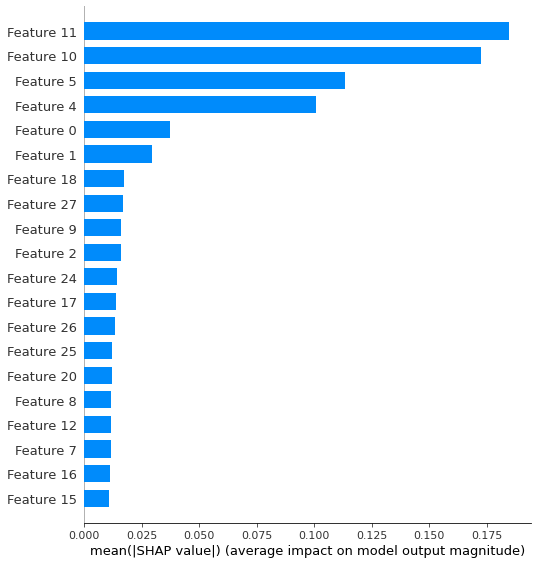

In [141]:
shap.summary_plot(shap_values, X_test_shap, plot_type="bar")

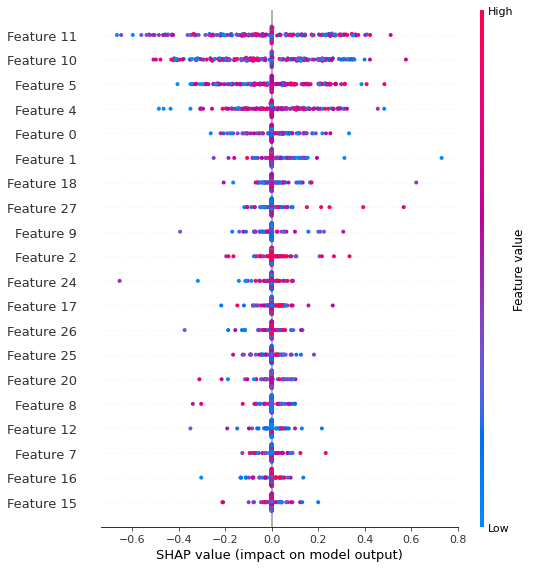

In [142]:
shap.summary_plot(shap_values, X_test_shap)

In [149]:
INSTANCE_NUM = 0
shap.force_plot(explainer, shap_values[0], X_test_shap[INSTANCE_NUM])

In [154]:
NUM_ROWS = 10
shap.force_plot(explainer, shap_values[0], X_test_shap[4])

## Nauczenie modelu na całym dostępnym zbiorze danych i zapis go w celu wykorzystania do do interaktywnego notebooka

In [112]:
#Zapis modelu do pliku
best_estimator = SVC(**clf_fromStart_grid.best_params_)
dataset_final = prepare_dataset(all_seasons, list_of_parameters, all_data_past,
                          add_direct = True, avg = 3, train_size = 1.0, test_size = 0.0,
                          undersample = True, globalCS = False)

best_estimator.fit(dataset_final['X_train'], dataset_final['y_train'])
ex_filename = os.path.join(os.path.join(Path(os.getcwd()), 'saved'), 'SVM.pkl')
with open(ex_filename, "wb") as f:
    pickle.dump(clf_fromStart_grid.best_estimator_, f)